In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import constants as const
from phidl import quickplot as qp
from phidl import Device
from phidl import CrossSection
from phidl import Path
import phidl.geometry as pg
import phidl.routing as pr
import phidl.path as pp
import pprint

In [5]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / 'util/'))
import qubit_templates
from qubit_templates import *
from functions import *

# Read configuration file

In [6]:
wafertype = "silicon" # silicon or sapphire
JJtype = "dl" # (mh or dl) manhattan or dolan
Squid = True
Bandage = False

outname = "waferdesign_3D_" + wafertype + "_" + JJtype
if Bandage:
    outname += "bd" 

config = load_config( f"config/common.yaml" )
globals().update(config)
qubit_templates.__dict__.update(config)

config = load_config( f"config/dolan_3D_{wafertype}.yaml" )
globals().update(config)
qubit_templates.__dict__.update(config)

# Wafer design

In [7]:
wafer = device_Wafer(inch = 4)

# Chip design

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


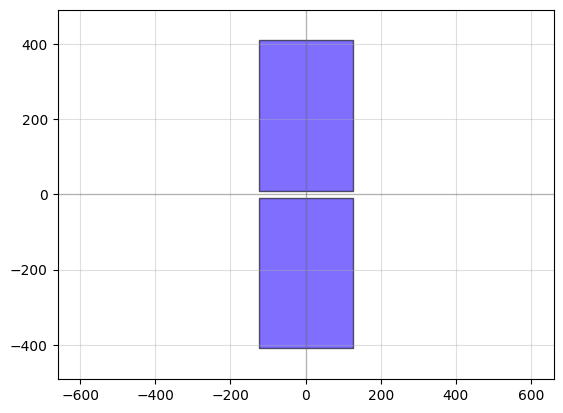

In [8]:
chipdesign = Device('chipdesign')

PAD=Device('PAD')
rectangle = pg.rectangle(( Pad_width, Pad_height), Pad_layer)
PAD.add_ref( rectangle ).movex(0).movey(0.5*Pad_gap)
PAD.add_ref( rectangle ).mirror(p1 = (0, 0), p2 = (200, 0)).movex(0).movey(-0.5*Pad_gap)
PAD.center = (0, 0)

chipdesign.add_ref(PAD)

# Quickplot the imported design
qp(chipdesign)

# Josephson Junction

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


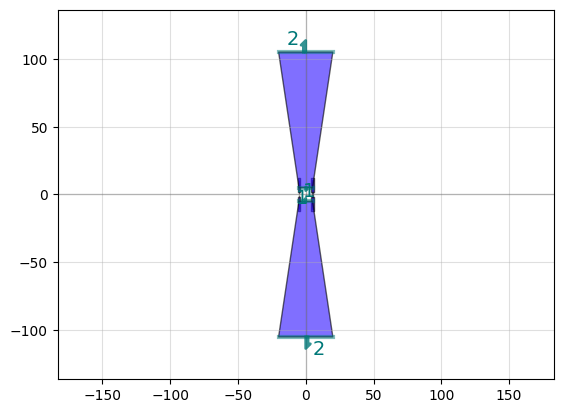

In [9]:
# JJ = device_JJ(width = 0.3, JJtype = "manhattan", squid = True, bandage = False)
# JJ = device_JJ(width = 0.3, JJtype = "manhattan", squid = False, bandage = False)
# JJ = device_JJ(width = 0.135, JJtype = "manhattan", squid = True, bandage = True)
# JJ = device_JJ(width = 0.135, JJtype = "manhattan", squid = False, bandage = True)
JJ = device_JJ(width = 1.0, JJtype = "dolan", squid = True, bandage = False)
# JJ = device_JJ(width = 1.0, JJtype = "dolan", squid = False, bandage = False)
# JJ = device_JJ(width = 1.0, JJtype = "dolan", squid = True, bandage = True)
# JJ = device_JJ(width = 1.0, JJtype = "dolan", squid = False, bandage = True)
qp(JJ)


# Add JJ to chip design

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


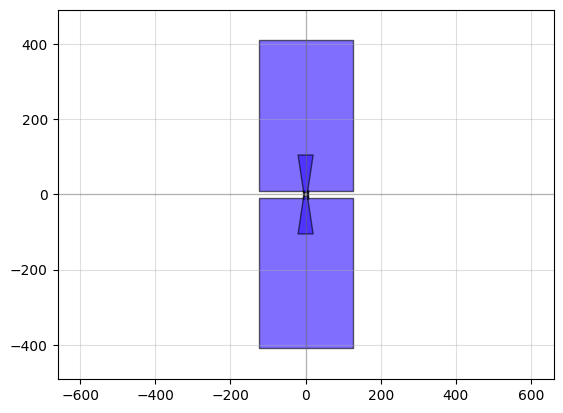

'output/chipdesign_3D.gds'

In [10]:
def custom_chip(bridge_width, finger_width):
    chip = Device('chip')
    chip.add_ref(chipdesign)

    JJ = device_JJ(bridge_width = bridge_width, finger_width = finger_width, JJtype = JJtype, squid = Squid , bandage = Bandage)

    chip.add_ref(JJ)

    return chip

chip = custom_chip(bridge_width = 1.0, finger_width = 0.2)
qp(chip)
chip.write_gds('output/chipdesign_3D')

# Place chip designs

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


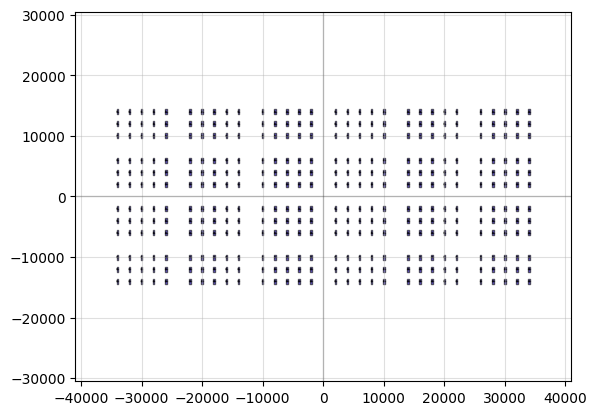

In [11]:
def custom_design(size_x, size_y, bridge_width, finger_width):
    design = pg.gridsweep(
        function = custom_chip,
        param_x = {'bridge_width' : bridge_width},
        param_y = {'finger_width' : finger_width},
        spacing = (size_x, size_y),
        separation = False,
        label_layer = None
        )
    design.center = (0,0)
    return design

if wafertype == "sapphire":
    D = pg.gridsweep(
            function = custom_design,
            param_x = {'bridge_width' : Grid_bridge_width },
            param_y = {'finger_width' : Grid_finger_width },
            param_defaults = {'size_x' : Chip_size_x, 'size_y' : Chip_size_y},
            spacing = (Chip_size_x * (len(Grid_bridge_width[0]) + Grid_gap_x), Chip_size_y * (len(Grid_finger_width[0]) + Grid_gap_y)),
            separation = False,
            label_layer = None
            )
    # D.center = ( - 0.5 * len(Grid_bridge_width) * Chip_size_x * (len(Grid_bridge_width[0]) + Grid_gap_x) ,0)
    D.center = ( 0 ,0)
    wafer.add_ref(D)

    # D = pg.gridsweep(
    #         function = custom_design,
    #         param_x = {'bridge_width' : Grid_small_bridge_width },
    #         param_y = {'finger_width' : Grid_small_finger_width },
    #         param_defaults = {'size_x' : Chip_small_size_x, 'size_y' : Chip_small_size_y},
    #         spacing = (Chip_small_size_x * (len(Grid_small_bridge_width[0]) + Grid_small_gap_x), Chip_small_size_y * (len(Grid_small_finger_width[0]) + Grid_small_gap_y)),
    #         separation = False,
    #         label_layer = None
    #         )
    # D.center = ( 0.5 * len(Grid_small_bridge_width) * Chip_small_size_x * (len(Grid_small_bridge_width[0]) + Grid_small_gap_x) ,0)


    # wafer.add_ref(D)
    qp(D)

else:
    D = pg.gridsweep(
            function = custom_design,
            param_x = {'bridge_width' : Grid_bridge_width },
            param_y = {'finger_width' : Grid_finger_width },
            param_defaults = {'size_x' : Chip_size_x, 'size_y' : Chip_size_y},            
            spacing = (Chip_size_x * (len(Grid_bridge_width[0]) + Grid_gap_x), Chip_size_y * (len(Grid_finger_width[0]) + Grid_gap_y)),
            separation = False,
            label_layer = None
            )
    D.center = (0,0)

    wafer.add_ref(D)
    qp(D)

# Place dicing marker

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


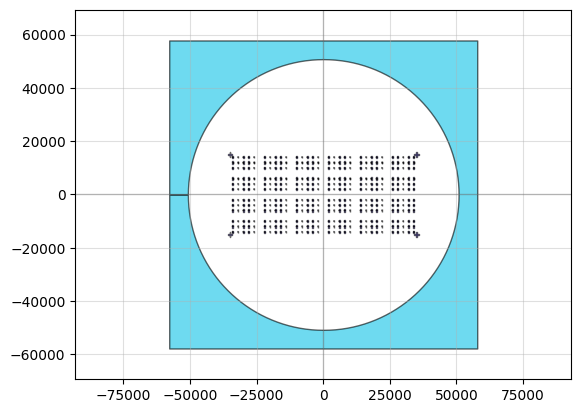

In [12]:

if wafertype == "sapphire":
    DicingMarker = device_DicingMarkers(
        width  = DicingMarker_width, 
        length = DicingMarker_length, 
        layer  = DicingMarker_layer
    )

    spacing_x = Chip_size_x * Grid_gap_x * (len(Grid_bridge_width) - 1) + Chip_size_x * len(Grid_bridge_width) * len(Grid_bridge_width[0])
    spacing_y = Chip_size_y * Grid_gap_y * (len(Grid_finger_width) - 1) + Chip_size_y * len(Grid_finger_width) * len(Grid_finger_width[0])

    # wafer.add_ref(DicingMarker).center = (0, 0)

    wafer.add_ref(DicingMarker).center = (-0.5*spacing_x, -0.5*spacing_y)
    wafer.add_ref(DicingMarker).center = (-0.5*spacing_x,  0.5*spacing_y)
    wafer.add_ref(DicingMarker).center = ( 0.5*spacing_x, -0.5*spacing_y)
    wafer.add_ref(DicingMarker).center = ( 0.5*spacing_x,  0.5*spacing_y)

    # wafer.add_ref(DicingMarker).center = (-spacing_x, -0.5*spacing_y)
    # wafer.add_ref(DicingMarker).center = (-spacing_x,  0.5*spacing_y)
    # wafer.add_ref(DicingMarker).center = (         0, -0.5*spacing_y)
    # wafer.add_ref(DicingMarker).center = (         0,  0.5*spacing_y)

    # spacing_x = Chip_small_size_x * Grid_small_gap_x * (len(Grid_small_bridge_width) - 1) + Chip_small_size_x * len(Grid_small_bridge_width) * len(Grid_small_bridge_width[0])
    # spacing_y = Chip_small_size_y * Grid_small_gap_y * (len(Grid_small_finger_width) - 1) + Chip_small_size_y * len(Grid_small_finger_width) * len(Grid_small_finger_width[0])

    # # wafer.add_ref(DicingMarker).center = (0, 0)

    # wafer.add_ref(DicingMarker).center = ( spacing_x, -0.5*spacing_y)
    # wafer.add_ref(DicingMarker).center = ( spacing_x,  0.5*spacing_y)
    # wafer.add_ref(DicingMarker).center = ( 0, -0.5*spacing_y)
    # wafer.add_ref(DicingMarker).center = ( 0,  0.5*spacing_y)

else:
    DicingMarker = device_DicingMarkers(
        width  = DicingMarker_width, 
        length = DicingMarker_length, 
        layer  = DicingMarker_layer
    )

    spacing_x = Chip_size_x * Grid_gap_x * (len(Grid_bridge_width) - 1) + Chip_size_x * len(Grid_bridge_width) * len(Grid_bridge_width[0])
    spacing_y = Chip_size_y * Grid_gap_y * (len(Grid_finger_width) - 1) + Chip_size_y * len(Grid_finger_width) * len(Grid_finger_width[0])

    # wafer.add_ref(DicingMarker).center = (0, 0)

    wafer.add_ref(DicingMarker).center = (-0.5*spacing_x, -0.5*spacing_y)
    wafer.add_ref(DicingMarker).center = (-0.5*spacing_x,  0.5*spacing_y)
    wafer.add_ref(DicingMarker).center = ( 0.5*spacing_x, -0.5*spacing_y)
    wafer.add_ref(DicingMarker).center = ( 0.5*spacing_x,  0.5*spacing_y)

# wafer.add_ref(DicingMarker).center = ( 0, -0.5*spacing_y)
# wafer.add_ref(DicingMarker).center = ( 0,  0.5*spacing_y)
# wafer.add_ref(DicingMarker).center = ( -0.5*spacing_x, 0)
# wafer.add_ref(DicingMarker).center = (  0.5*spacing_x, 0)

qp(wafer)

In [13]:
wafer.write_gds('output/' + outname)

'output/waferdesign_3D_silicon_dl.gds'